# Salary and Education in Wisconsin

This notebook is intended to describe analysis on salaries of teachers within the Wisconsin Department of Public Instruction.

## Preparation

### Load libraries
Only needed to load data to BigQuery

In [0]:
!pip install gcsfs
!pip install pandas-gbq -U
import gcsfs

### Import Libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.cloud import bigquery

In [0]:
%matplotlib inline
plt.style.use('bmh')

In [0]:
project_id='wi-dpi-010'
raw_data_bucket_name='landing-009'
source_name='all_staff_report'
year='2017_2018'
filename='AllStaffReportPublic__04152019_194414.csv'
full_filename=raw_data_bucket_name + '/' + source_name + '/' + year + '/' + filename

dataset_name='landing'
table_name=source_name
landing_bq_fullname=dataset_name + '.' + table_name



### Functions

In [0]:
def create_dataset(client, project_id, dataset_name):
  
  
  dataset_id = "{}.{}".format(project_id, dataset_name)
  dataset = bigquery.Dataset(dataset_id)
  dataset.location = "US"

  dataset = client.create_dataset(dataset)
  print("Created dataset {}.{}".format(client.project, dataset.dataset_id))

In [0]:
def convert_currency(val):
    """
    Convert the string number value to a float
     - Remove $
     - Remove commas
     - Convert to float type
    """
    new_val = val.replace(',','').replace('$', '')
    return float(new_val)

### Load Data

Data can be retrieved from the GCP Bucket.

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
client = bigquery.Client(project_id)

In [0]:
create_dataset(client, project_id, dataset_name)

In [0]:
fs = gcsfs.GCSFileSystem(project=project_id)
with fs.open(full_filename) as f:
  df = pd.read_csv(f, skiprows=1)

In [0]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df.to_gbq(landing_bq_fullname,project_id=project_id,if_exists='replace')

# Exploratory Data Analysis

The following fields are Integers; but have Nulls in the columns. 

As such they are loaded as floats:

1.  entity_id
2.  assignment_work_cesa_number
3.  district_mailing_po_box


In [0]:
query = '''
  SELECT
    *
  FROM
    [{project}.{dataset}.{table}]
 '''.format(project=project_id, dataset=dataset_name, table=table_name)

In [6]:
df = pd.io.gbq.read_gbq(query, project_id=project_id, reauth=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value for dialect is changing to "standard" in a future version of pandas-gbq. Pass in dialect="legacy" to disable this warning.
  """Entry point for launching an IPython kernel.


Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=495642085510-k0tmvj2m941jhre2nbqka17vqpjfddtd.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=5i3n8OBz8iE9vOJglm3ftYcnGNA0Bx&prompt=consent&access_type=offline
Enter the authorization code: 4/NQHt-pktFhy3rLlqgobuKmKxgr3X8omOquq-IsRy79vPXrTc8fCCPvU


In [7]:
df.head()

,research_id,school_year,last_name,first_name,entity_id,gender,raceethnicity,birth_year,contract_hire_agency,contract_high_degree,...,school_mailing_street_address,school_mailing_po_box,school_mailing_city,school_mailing_state,school_mailing_zip_code,district_mailing_street_address,district_mailing_po_box,district_mailing_city,district_mailing_state,district_mailing_zip_code
0,90313,2018,Anderson,Gayle,673393.0,F,W - White,1948,None,None,...,755 Scheuring Rd,None,De Pere,WI,54115.0,755 Scheuring Rd,NaN,De Pere,WI,54115
1,23255,2018,Boudreau,Jennifer,440950.0,F,W - White,1967,None,None,...,755 Scheuring Rd,None,De Pere,WI,54115.0,755 Scheuring Rd,NaN,De Pere,WI,54115
2,148857,2018,Burkard,Brenda,808929.0,F,W - White,1971,None,None,...,755 Scheuring Rd,None,De Pere,WI,54115.0,755 Scheuring Rd,NaN,De Pere,WI,54115
3,78347,2018,Doucette,Patrick,57697.0,M,W - White,1951,None,None,...,755 Scheuring Rd,None,De Pere,WI,54115.0,755 Scheuring Rd,NaN,De Pere,WI,54115
4,40518,2018,Fossen-Rades,Christine,53515.0,F,W - White,1969,None,None,...,755 Scheuring Rd,None,De Pere,WI,54115.0,755 Scheuring Rd,NaN,De Pere,WI,54115


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187344 entries, 0 to 187343
Data columns (total 44 columns):
research_id                        187344 non-null int64
school_year                        187344 non-null int64
last_name                          187344 non-null object
first_name                         187344 non-null object
entity_id                          142718 non-null float64
gender                             187344 non-null object
raceethnicity                      187344 non-null object
birth_year                         187344 non-null int64
contract_hire_agency               107926 non-null object
contract_high_degree               107898 non-null object
contract_days                      107926 non-null float64
contract_local_experience          107926 non-null float64
contract_total_experience          107926 non-null float64
total_salary                       107926 non-null object
total_fringe                       107898 non-null object
assignment_area   

In [9]:
# df.count() does not include NaN values
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
#del df2['Id']
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2

List of dropped columns: school_mailing_po_box, district_mailing_po_box, 



In [0]:
df['total_salary'] = df['total_salary'].apply(lambda x: convert_currency(x) if pd.notnull(x) else x)
#df['total_salary'].map(convert_currency({}), na_action='ignore')

In [22]:
df['total_salary'][df['total_salary'].notnull()]

208       17664.0
280       25549.0
374       31391.0
375       12615.0
376       18713.0
529       22526.0
612       21000.0
613       25200.0
685        4319.0
1004      21802.0
1005      26386.0
1455       5000.0
1509       8825.0
1510       8825.0
1511       8825.0
1512       8825.0
1991      22701.0
2095      11500.0
2173       5599.0
2274      22965.0
2733       8425.0
2734       2500.0
2790      18926.0
2967      20000.0
3329      12086.0
3330      21057.0
3331       6612.0
3343       7363.0
3482      24016.0
4057      19067.0
           ...   
183240    20000.0
184352     7809.0
184373    16099.0
185512    40833.0
185513    42787.0
185514    63464.0
185515    28041.0
185516    56371.0
185517    56371.0
185518    45270.0
185519     4673.0
185520    34204.0
185521    36744.0
185522    32709.0
185523    48504.0
185524    44994.0
185525    33165.0
185526    40833.0
185527    63464.0
185528    49242.0
185529    45931.0
185530    39545.0
185531    37759.0
185532    33821.0
185533    

count    107926.000000
mean      56725.224283
std       16923.958347
min         258.000000
25%       44984.000000
50%       55000.000000
75%       65890.000000
max      255000.000000
Name: total_salary, dtype: float64


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


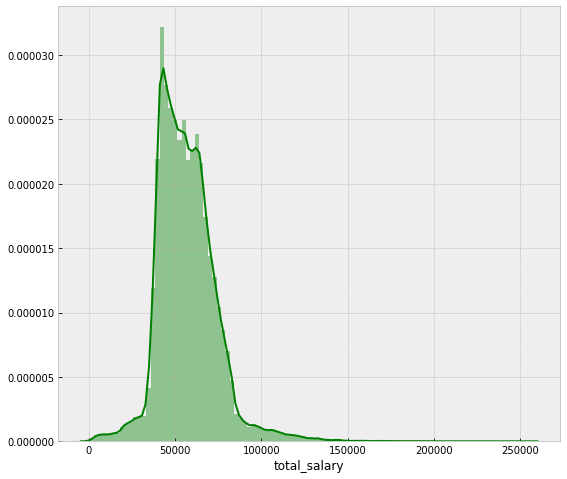

In [24]:
print(df['total_salary'].describe())
plt.figure(figsize=(9, 8))
#sns.distplot(df['total_salary'], color='g', bins=100);
sns.distplot(df['total_salary'], color='g', bins=100, hist_kws={'alpha': 0.4})